In [1]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
from getplate import getPlate
from getdisc import GetDisc
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, clear_output
import matplotlib.animation as animation
from IPython.display import HTML, clear_output
from scipy.constants import Avogadro as avogadro

C:\Users\matss\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%%html 
<style>
.output_wrapper button.btn.btn-default, .output_wrapper .ui-dialog-titlebar {
    display: none;
} </style>

In [3]:
def quadratureTable2D(N):
    '''
    Takes in N, number of quadrature points and returns the quadrature 
    nodes and weights
    '''
    if N == 1:
        zeta = np.array([[1/3,1/3,1/3]])
        rho = np.array([1])
    elif N == 3:
        zeta = np.array([[1/2, 1/2, 0],
                        [1/2, 0, 1/2],
                        [0, 1/2, 1/2]])
        rho = np.array([1/3, 1/3, 1/3])
    elif N == 4:
        zeta = np.array([[1/3, 1/3, 1/3],
                      [3/5, 1/5, 1/5],
                      [1/5, 3/5, 1/5],
                      [1/5, 1/5, 3/5]])
        rho = np.array([-9/16, 25/48, 25/48, 25/48])
    return zeta, rho

def quadrature2D(p1, p2, p3, Nq, g):
    '''
    Gives approximation of integral of function g
    on area defined by corners p1, p2, p3
    Nq gives number of quadrature points to be used
    '''
    zeta, rho = quadratureTable2D(Nq)
    # Scaling weights using area, area calculated from formula taking in the three vertices
    Area = 1/2 * (p1[0]*(p2[1] - p3[1]) + p2[0]*(p3[1]-p1[1]) + p3[0]*(p1[1]-p2[1]))
    rho = rho * Area
    #I = g(zeta[:,0]*p1 + zeta[:,1]*p2 + zeta[:,2]*p3)@rho
    I = 0
    for i in range(len(zeta)):
        I += g(zeta[i,0] * p1 + zeta[i,1] * p2 + zeta[i,2] * p3) * rho[i]   
    return I

In [4]:
def unitfnc(x):
    return 1

def assembleAh_k(p, elem):
    M = np.ones((3,3))
    index = np.array([elem[0], elem[1], elem[2]])
    points = p[index]
    M[:,1] = points[:,0]
    M[:,2] = points[:,1]
    C_1 = np.linalg.solve(M, np.array([1,0,0]))
    C_2 = np.linalg.solve(M, np.array([0,1,0]))
    C_3 = np.linalg.solve(M, np.array([0,0,1]))
    C = np.array([C_1, C_2, C_3])
    
    Ah_k = np.zeros((3,3))
    Area = quadrature2D(points[0], points[1], points[2], 4, unitfnc)
    for alpha in range(3):
        for beta in range(3):
            Ah_k[alpha,beta] = Area * (C[alpha,1] * C[beta,1] + C[alpha,2] * C[beta,2])
    return Ah_k
    
def assembleAh(N, p, tri):
    Ah = np.zeros((N,N))
    for k in range(len(tri)):
        Ah_k = assembleAh_k(p, tri[k])
        for alpha in range(3):
            i = tri[k,alpha]
            for beta in range(3):
                j = tri[k,beta]
                Ah[i,j] += Ah_k[alpha, beta]
    return Ah


In [5]:
def assembleMh_k(p, elem):
    M = np.ones((3,3))
    index = np.array([elem[0], elem[1], elem[2]])
    points = p[index]
    M[:,1] = points[:,0]
    M[:,2] = points[:,1]
    C_1 = np.linalg.solve(M, np.array([1,0,0]))
    C_2 = np.linalg.solve(M, np.array([0,1,0]))
    C_3 = np.linalg.solve(M, np.array([0,0,1]))
    C = np.array([C_1, C_2, C_3])
    
    Mh_k = np.zeros((3,3))
    for alpha in range(3):
        for beta in range(3):
            Ha = lambda X: C[alpha,0] + C[alpha,1] * X[0] + C[alpha,2] * X[1]
            Hb = lambda X: C[beta,0] + C[beta,1] * X[0] + C[beta,2] * X[1]
            Hf = lambda X: Ha(X) * Hb(X)
            Mh_k[alpha,beta] = quadrature2D(points[0], points[1], points[2], 4, Hf) 
    return Mh_k
    
def assembleMh(N, p, tri):
    Mh = np.zeros((N,N))
    for k in range(len(tri)):
        Mh_k = assembleMh_k(p, tri[k])
        for alpha in range(3):
            i = tri[k,alpha]
            for beta in range(3):
                j = tri[k,beta]
                Mh[i,j] += Mh_k[alpha, beta]
    return Mh

In [6]:
def assembleBh_k(p, elem):
    M = np.ones((3,3))
    index = np.array([elem[0], elem[1], elem[2]])
    points = p[index]
    M[:,1] = points[:,0]
    M[:,2] = points[:,1]
    C_1 = np.linalg.solve(M, np.array([1,0,0]))
    C_2 = np.linalg.solve(M, np.array([0,1,0]))
    C_3 = np.linalg.solve(M, np.array([0,0,1]))
    C = np.array([C_1, C_2, C_3])
    
    Bh_k = np.zeros((3,3,3))
    for alpha in range(3):
        for beta in range(3):
            for gamma in range(3):
                Ha = lambda X: C[alpha,0] + C[alpha,1] * X[0] + C[alpha,2] * X[1]
                Hb = lambda X: C[beta,0] + C[beta,1] * X[0] + C[beta,2] * X[1]
                Hc = lambda X: C[gamma,0] + C[gamma,1] * X[0] + C[gamma,2] * X[1]
                Hf = lambda X: Ha(X) * Hb(X) * Hc(X)
                Bh_k[alpha,beta,gamma] = quadrature2D(points[0], points[1], points[2], 4, Hf) 
    return Bh_k
    
def assembleBh(N, p, tri):
    Bh = np.zeros((N, N, N))
    for k in range(len(tri)):
        Bh_k = assembleBh_k(p, tri[k])
        for alpha in range(3):
            i = tri[k,alpha]
            for beta in range(3):
                j = tri[k,beta]
                for gamma in range(3):
                    k = tri[k, gamma]
                    Bh[i,j,k] += Bh_k[alpha, beta, gamma]
    return Bh

In [7]:
def assembleFh_k(p, elem, f):
    M = np.ones((3,3))
    index = np.array([elem[0], elem[1], elem[2]])
    points = p[index]
    M[:,1] = points[:,0]
    M[:,2] = points[:,1]
    C_1 = np.linalg.solve(M, np.array([1,0,0]))
    C_2 = np.linalg.solve(M, np.array([0,1,0]))
    C_3 = np.linalg.solve(M, np.array([0,0,1]))
    C = np.array([C_1, C_2, C_3])
    
    Fh_k = np.zeros(3)
    for alpha in range(3):
        H = lambda X : C[alpha,0] + C[alpha,1] * X[0] + C[alpha,2] * X[1]
        Hf = lambda X : H(X) * f(X)
        Fh_k[alpha] = quadrature2D(points[0], points[1], points[2], 4, Hf)
    return Fh_k

def assembleFh(N, p, tri, f):
    Fh = np.zeros(N)
    for k in range(len(tri)):
        Fh_k = assembleFh_k(p, tri[k], f)
        for alpha in range(3):
            i = tri[k, alpha]
            Fh[i] += Fh_k[alpha]
    return Fh

In [74]:
# Constants
k1 = 4e6 #volum / mol*s
k_1 = 5 #k_{-1} # 1/s
L1 = 0.22e-6
#R0 = 1.66e-27
#N0 = 5.463e-8
N0 = 5000/(np.pi*L1**2*avogadro) # mol/m^2
R0 = 1000e-12 /avogadro          # mol/m^2
kappa = 0.22e-12
T = L1**2/kappa

print(T)
T1 = 1/(k1*R0)
print(T1)
T2 = N0/(k_1*R0)
print(T2)



alpha = k1*L1**2*R0 / kappa
beta = k_1*L1**2*R0 / N0*kappa

0.22000000000000003
1.5055351899999997e+26
6.576650540987409e+24


In [53]:
# Constants
k1 = 4e6 #volum / mol*s
k_1 = 5 #k_{-1} # 1/s
L1 = 0.22e-6
#R0 = 1.66e-27
#N0 = 5.463e-8
N0 = 5000/(np.pi*L1**2*avogadro) # mol/m^2
R0 = 1000e-12 /avogadro          # mol/m^2
kappa = 0.22e-12
T = L1**2/kappa

T1 = 1/(k1*N0)
T2 = 1/k_1

print(T)
print(T1)
print(T2)

alpha = k1*L1**2*R0 / kappa
beta = k_1*L1**2*R0 / (N0*kappa)

0.22000000000000003
4.578425387260917
0.2
20.81102448754962


In [54]:
N = 100

# Ikke gitt at PDE'en konserverer masse
# Neumann 0 hindrer ikke at noe forsvinner, bare at slope er 0
# Bubble function as initial condition??
    
def forwardEuler(N, numStepsTime):
    '''
    '''
    p, tri, edge = GetDisc(N)

    A = assembleAh(N, p, tri)
    B = assembleBh(N, p, tri)
    M = assembleMh(N, p, tri)
    Minv = np.linalg.inv(M)
    
    gamma = k1*T*N0
    ksi = k_1*T

    #initial conditions

    n = np.zeros(N)
    r = np.ones(N)/N
    c = np.zeros(N)
    
    n[0] = 1
    
    # Kjegle, N = 100
    # n[0] = 1
    # n[1:7] = 0.8
    # n[7:19] = 0.6
    # n[19:37] = 0.4
    # n[37:62] = 0.2
    # n = n/np.sum(n)
    
    #n[0:7] = 1/7
    #plot3D(p, n)


    nvec = [n]
    rvec = [r]
    cvec = [c]
    
    stab = 2/np.max(np.linalg.eig(Minv@A)[0])
    # Forward Euler:
    dT = 1/numStepsTime
    print(dT < stab)
    for j in range(21*numStepsTime):
    #for j in range(10000):
        #print(np.sum(n))
        #n_new = n + dT*(Minv@A - M@A.T@Minv)@n
        #n_new = np.linalg.solve(M - dT*A + dT*M@A.T@Minv, M@n)
        #n_new = np.linalg.solve()
        n_new = n - dT*Minv@A@n - dT*alpha*Minv@B@r@n + dT*beta*Minv@M@c
        #print(np.sum(dT*Minv@A@n))
        #print(np.sum(dT*Minv@B@r@n))
        #print(np.sum(dT*Minv@D@c))
        #print(" ")
        r_new = r - dT*gamma*r*n + dT*ksi*c
        #delta = r_new - r
        #c_new = c - delta
        c_new = c + dT*gamma*r*n - dT*ksi*c
        nvec.append(n_new)
        rvec.append(r_new)
        cvec.append(c_new)
        n = n_new
        r = r_new
        c = c_new
    
    return nvec, rvec, cvec, p, tri

nvec, rvec, cvec, p, tri = forwardEuler(N, 2000)

True


[[0.19372963 0.         0.02703204 ... 0.         0.         0.        ]
 [0.         0.         0.01351602 ... 0.         0.         0.        ]
 [0.         0.         0.02703204 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[0.         0.         0.01351602 ... 0.         0.         0.        ]
 [0.         0.         0.02703204 ... 0.         0.         0.        ]
 [0.         0.         0.02703204 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


<IPython.core.display.Javascript object>


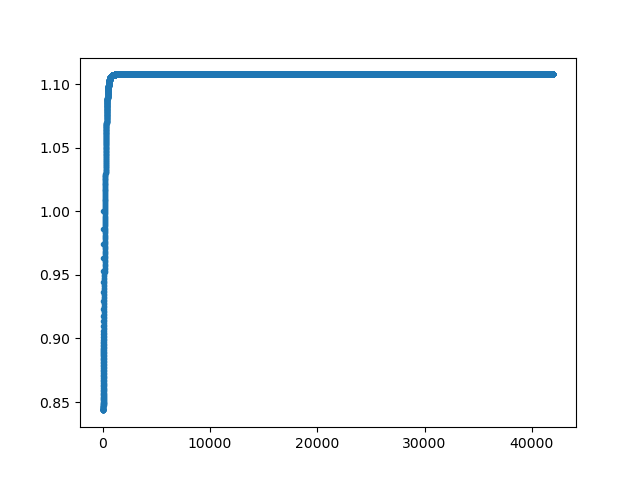

In [55]:
vec = []
for row in nvec:
    vec.append(np.sum(row))


plt.figure()
plt.plot(vec, ".")
plt.show()

<IPython.core.display.Javascript object>


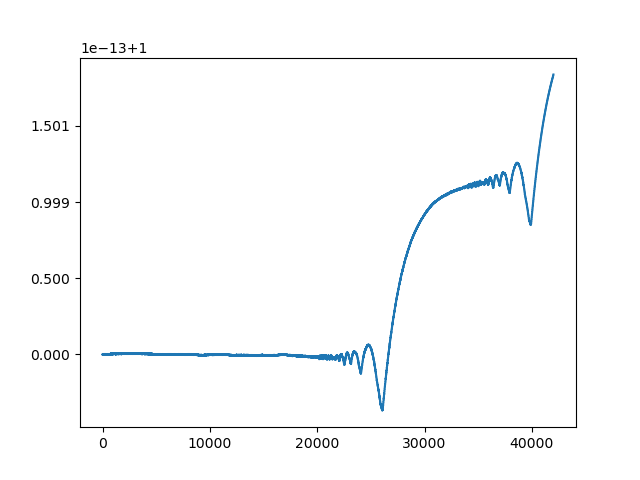

In [56]:
rcvec = []
for i in range(len(rvec)):
    rcvec.append(np.sum(cvec[i]) + np.sum(rvec[i]))
    
plt.figure()
plt.plot(rcvec)
plt.show()

In [ ]:
def contourplotter(p, tri, uApprox, N):
    x = p[:,0]
    y = p[:,1]
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)


    fig.set_figheight(4)
    fig.set_figwidth(16)

    im1 = ax1.tricontourf(x, y, tri, uApprox)
    ax1.set_title("Approximation")
    plt.colorbar(im1, ax=ax1)
    
contourplotter(p, tri, n_new, N)    

In [40]:
%%capture
def animate_n(ui, fps):
    dt = 1/fps
    fig, ax = plt.subplots()
    ui = np.array(ui)
    maxVal = np.max(ui)
    print(maxVal)
    
    #x = ui[-1]
    #pcm = ax.tricontourf(p[:,0], p[:,1], tri, x, vmin = 0, vmax = maxVal)
    #fig.colorbar(pcm)
    
    #Method to change the contour plot
    def animate(i):
        ax.clear()
        x = ui[i]
        pcm = ax.tricontourf(p[:,0], p[:,1], tri, x)#, vmin = 0, vmax = maxVal)
        #fig.colorbar(pcm)
    
    
    ani = animation.FuncAnimation(fig, animate, frames = (len(ui)//10), interval=dt*1000, repeat = False)
    
    return HTML(ani.to_jshtml())

ani = animate_n(cvec, 1000)

In [63]:
print(rvec[-1]*nvec[-1]/cvec[-1] - k_1/(N0*k1))

print(cvec[-1])

[-1.55857549e-11  1.02028253e-09  1.02049924e-09  1.01959330e-09
  1.01985265e-09  1.01952580e-09  1.02002673e-09  1.78419057e-09
  1.77133685e-09  1.78411952e-09  1.77054460e-09  1.78395254e-09
  1.76970616e-09  1.78387083e-09  1.77048420e-09  1.78373583e-09
  1.77007919e-09  1.78415505e-09  1.77146831e-09  2.15974438e-09
  2.14933493e-09  2.16027729e-09  2.16279261e-09  2.15080576e-09
  2.15885265e-09  2.16221707e-09  2.15061746e-09  2.15872475e-09
  2.16260787e-09  2.15106866e-09  2.16224194e-09  2.15885265e-09
  2.15044693e-09  2.16224549e-09  2.16007123e-09  2.15409912e-09
  2.15963780e-09  2.34960496e-09  2.34931719e-09  2.33659136e-09
  2.34907560e-09  2.34850717e-09  2.34517827e-09  2.34564013e-09
  2.34964759e-09  2.34795294e-09  2.34477326e-09  2.34581776e-09
  2.34868125e-09  2.34688713e-09  2.34524933e-09  2.34858177e-09
  2.34549091e-09  2.34459563e-09  2.34738451e-09  2.34927811e-09
  2.34502551e-09  2.34502906e-09  2.34817321e-09  2.34917152e-09
  2.34145503e-09  2.34925

In [41]:
display(ani)

In [ ]:
def plot3D(p, u):
    """
    Takes in a list of (x, y) cordinates p, a numerical solution and an exact solution. Plots the
    numerical solution, exact solution and the error.
    """
    fig = plt.figure(figsize=(18, 6))
    
    ax = fig.add_subplot(1, 3, 1, projection="3d")
    ax.plot_trisurf(p[:, 0], p[:, 1], u, linewidth=0.2)
    ax.set_title("Numerical")

In [ ]:
for i in range(0, len(nvec), 100):
    plot3D(p, nvec[i])

In [ ]:
def backwardEuler(N, numStepsTime):
    '''
    '''
    p, tri, edge = GetDisc(N)

    A = assembleAh(N, p, tri)
    B = alpha*assembleBh(N, p, tri)
    M = assembleMh(N, p, tri)
    D = beta*M
    Minv = np.linalg.inv(M)
    
    gamma = k1*T*N0
    ksi = k_1*T

    #initial conditions

    n = np.zeros(N)
    r = np.zeros(N)
    c = np.zeros(N)

    n[0] = 1
    r[:N-len(edge)] += 1/(N-len(edge))

    nvec = [n]
    rvec = [r]
    cvec = [c]

    dT = 1/numStepsTime
    #for j in range(numStepsTime):
    for j in range(100):
        n_new = np.linalg.solve(M + dT*A + dT*B@r, dT*D@c + M@n)
        r_new = -gamma*r*n + ksi*c
        delta = r_new - r
        c_new = c - delta
        nvec.append(n_new)
        rvec.append(r_new)
        cvec.append(c_new)
        n = n_new
        r = r_new
        c = c_new
    
    return nvec, rvec, cvec, p, tri